# GLADs Intersecting AOIs

In [1]:
#Import Global Metadata etc

%run '0.Importable_Globals.ipynb'

In [2]:
from datetime import date
from datetime import timedelta
import datetime

# Standard Rank Approach

Allows users to rank regions withing an iso, or adm1, by the amount of GLAD alerts that have occured in a given time frame.

e.g. https://production-api.globalforestwatch.org/query/b6c75127-85c1-42fa-81a4-088d313797bc?sql=SELECT%20*%20FROM%20data%20%20WHERE%20polyname%20=%20%27wdpa%27%20LIMIT%2010

See: https://basecamp.com/3063126/projects/10727890/todos/344440348

and: https://basecamp.com/3063126/projects/10727890/todos/344440348#comment_605072039

polynames: 

- 'gadm28'
- 'ifl_2013'
- 'wdpa'
- 'kba'
- 'aze'
- TCLs (tiger conservation landscapes) not sure...

Rank by:

- area of GLADs within region (ha)
- area of GLADs as a persentage of total extent

In [3]:
adm0 = 'BRA'
adm1 = None
polyname = 'gadm28'
threshold = 30     #hard code
extent_year = 2010 #hard coded since all glads data is post-2010
window = 12        #allow 4,12,26,52

sortBy = 'area_perc'

tags = ["forest_change", "Biodiversity"] #replaces current tree cover loss widget in summary

selectable_polynames = ['gadm28', 'kba', 'ifl_2013', 'wdpa', 'aze', 'tcl']

In [4]:
areaId_to_name = None
if adm1:
    tmp = get_admin2_json(iso=adm0, adm1=adm1)
    areaId_to_name ={}
    for row in tmp:
        areaId_to_name[row.get('adm2')] = row.get('name')
if iso and not adm1:
    tmp = get_admin1_json(iso=adm0)
    areaId_to_name={}
    for row in tmp:
        areaId_to_name[row.get('adm1')] = row.get('name') 

In [5]:
def glads_queries_by_poly(iso, adm1=None, polyname='gadm28'):
    #POLYNAME = gadm28, wdpa...
    # Return count for now (in case we change our mind). But do not include on prod
        url = f'https://production-api.globalforestwatch.org/query/b6c75127-85c1-42fa-81a4-088d313797bc?sql='
        if adm1:
            print(f'Requesting adm2 alerts')
            sql = f"""  SELECT iso, adm1, adm2, alert_count as count, alert_date as date, area_ha, polyname 
                        FROM data 
                        WHERE iso = '{iso}'
                        AND adm1 = {adm1}
                        AND polyname = '{polyname}'"""  
        elif iso:
            print(f'Requesting adm1 alerts')
            sql = f"""  SELECT iso, adm1, adm2, alert_count as count, alert_date as date, area_ha, polyname
                        FROM data 
                        WHERE iso = '{iso}'
                        AND polyname = '{polyname}'"""
        
        r = requests.get(url+sql)
        print(r.url)

        return r.json().get('data',None)#.get('attributes', None).get('value', None)


In [6]:
# Returns json object containing admin-codes, total area and extent (both in ha)
# If adm1 is not specified, it returns the total values for each adm1 region
# Else, returns the adm2 values within that adm1 region
# You may also specify a polyname (intersecting area) e.g. 'extent and % of plantations only'
# By default polyname is 'gadm28' (all forest extent)

def multiregion_extent_queries(adm0, adm1=None, year='area_extent_2000', p_name='gadm28', threshold=30):
    if adm0 and not adm1:
        print('Request for adm1 areas')
        sql = (f"SELECT adm1 as region, sum({year}) as extent, sum(area_gadm28) as total "
               f"FROM {ds} "
               f"WHERE iso = '{adm0}' "
                f"AND thresh = {threshold} "
               f"AND polyname = '{p_name}' "
               f"GROUP BY adm1 "
               f"ORDER BY adm1")
    elif adm0 and adm1:
        print('Request for adm2 areas')
        sql = (f"SELECT adm2 as region, {year} as extent, area_gadm28 as total "
                f"FROM {ds} "
                f"WHERE iso = '{adm0}' "
                f"AND thresh = {threshold} "
                f"AND polyname = '{p_name}' "
                f"AND adm1 = '{adm1}' ")
    return sql

In [7]:
def sumByAdm(data, adm1=None, window=4, sortBy='area_ha'):
    """Filters away dates outside of the past {window} weeks and then groups by adm"""
    if adm1:
        admin = 'adm2'
    else:
        admin = 'adm1'
        
    today = date.today()

    start = today.strftime('%Y/%m/%d')
    end = (today - timedelta(weeks=window-1)).strftime('%Y/%m/%d')
    
    tmp = []
    for d in data:
        if d.get(admin) not in tmp:
            tmp.append(d.get(admin))

    adm_list = []
    for adm in tmp:   
        adm_filter = list(filter(lambda x: (x.get(admin) == adm and x.get('date') >= end), data))
        total_area = total_count = 0
        ext = list(filter(lambda x: x.get('region') == adm, extent_data))[0].get('extent')
        for a in adm_filter:
            total_count += a.get('count')
            total_area += a.get('area_ha')
        
        adm_list.append({'adm': areaId_to_name[adm], 
                         'area_ha': total_area, 
                         'area_perc': 100 * total_area / ext
#                          'count': total_count,
#                          'count_per_ha': 100 * total_count / ext
                        })

    ranked_list = sorted(adm_list, key=lambda k: k[sortBy], reverse=True)
    
    return ranked_list

In [8]:
# Example sql and returned data


url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"
sql = multiregion_extent_queries(adm0, adm1, extent_year_dict[extent_year], polyname, threshold)


properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')



extent_data = r.json()['data']
glad_data = glads_queries_by_poly(iso=adm0, adm1=adm1, polyname=polyname)

sorted(glad_data, key=lambda k: k['date'], reverse=True)[0:5]

Request for adm1 areas
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+adm1+as+region%2C+sum%28area_extent%29+as+extent%2C+sum%28area_gadm28%29+as+total+FROM+499682b1-3174-493f-ba1a-368b4636708e+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+30+AND+polyname+%3D+%27gadm28%27+GROUP+BY+adm1+ORDER+BY+adm1
Status: 200
Requesting adm1 alerts
https://production-api.globalforestwatch.org/query/b6c75127-85c1-42fa-81a4-088d313797bc?sql=%20%20SELECT%20iso,%20adm1,%20adm2,%20alert_count%20as%20count,%20alert_date%20as%20date,%20area_ha,%20polyname%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20FROM%20data%20%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20WHERE%20iso%20=%20'BRA'%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20AND%20polyname%20=%20'gadm28'


[{'_id': 'AWIlMG9k8Jqrt1rpGePg',
  'adm1': 14,
  'adm2': 2461,
  'area_ha': 1.53172214532,
  'count': 20,
  'date': '2018/03/03',
  'iso': 'BRA',
  'polyname': 'gadm28'},
 {'_id': 'AWIlMIFj8Jqrt1rpGgXJ',
  'adm1': 11,
  'adm2': 1407,
  'area_ha': 246.28751342,
  'count': 3410,
  'date': '2018/03/03',
  'iso': 'BRA',
  'polyname': 'gadm28'},
 {'_id': 'AWIlMM0R8Jqrt1rpG2Z8',
  'adm1': 27,
  'adm2': 5444,
  'area_ha': 0.0758085900157,
  'count': 1,
  'date': '2018/03/03',
  'iso': 'BRA',
  'polyname': 'gadm28'},
 {'_id': 'AWIlMN8y8Jqrt1rpG7uP',
  'adm1': 10,
  'adm2': 1122,
  'area_ha': 0.383378617496,
  'count': 5,
  'date': '2018/03/03',
  'iso': 'BRA',
  'polyname': 'gadm28'},
 {'_id': 'AWIlMO_k8Jqrt1rpG_Id',
  'adm1': 27,
  'adm2': 5379,
  'area_ha': 2.58370015416,
  'count': 34,
  'date': '2018/03/03',
  'iso': 'BRA',
  'polyname': 'gadm28'}]

In [9]:
#Append ranking number using a list comprehension
ranked_data = [{'adm': x.get('adm'),
                'area_ha': x.get('area_ha'),
                'area_perc': x.get('area_perc'),
#                 'count': x.get('count'),
#                 'count_per_ha': x.get('count_per_ha'),
                'rank': i+1} for i,x in enumerate(sumByAdm(data=glad_data, adm1=adm1, window=window, sortBy=sortBy))]

In [10]:
ranked_data[0:5]

[{'adm': 'Mato Grosso do Sul',
  'area_ha': 494.6655611971297,
  'area_perc': 0.006574800588670704,
  'rank': 1},
 {'adm': 'Rio de Janeiro',
  'area_ha': 36.6372323529772,
  'area_perc': 0.002535577132552932,
  'rank': 2},
 {'adm': 'Bahia',
  'area_ha': 97.0283263590139,
  'area_perc': 0.0007045063011993706,
  'rank': 3},
 {'adm': 'Espírito Santo',
  'area_ha': 2.6996537054198,
  'area_perc': 0.00017626575391323882,
  'rank': 4},
 {'adm': 'Goiás',
  'area_ha': 5.2101882098229995,
  'area_perc': 8.81555638761906e-05,
  'rank': 5}]

# Dynamic Sentence

In [11]:
phrase_dict = {
    'gadm28': 'in',
    'wdpa': 'in protected areas within',
    'aze': 'in Alliance for Zero Extinction sites within',
    'ifl_2013': 'in intact forests within',
    'tcl': 'in tiger conservation landscapes within',
    'kba': 'in key biodiversity areas within'
}
    
if window == 4:
    timeframe = 'month'
elif window == 12:
    timeframe = '3 months'
elif window == 26:
    timeframe = '6 months'
elif window == 52:
    timeframe = 'year'

print(f"In the last {timeframe} ",end="")
print(f"{ranked_data[0].get('area_ha')} ha of GLAD alerts were detected {phrase_dict[polyname]} ",end="")
print(f"{ranked_data[0].get('adm')}, ",end="")
print(f"equivalent to a {ranked_data[0].get('area_perc')}% loss ",end="")
print(f"relative to 2010 tree cover extent.",end="")

In the last month 494.6655611971297 ha of GLAD alerts were detected in Mato Grosso do Sul, equivalent to a 0.006574800588670704% loss relative to 2010 tree cover extent.

# Experimental - DO NOT IMPLEMENT!

Could be interesting to plot counts vs time for the last X weeks for the top 5 admin regions experiencing the largest number of glad alerts.

In [12]:
def glads_queries_by_poly(iso, adm1=None, polyname='gadm28'):
    #POLYNAME = gadm28, wdpa...
        url = f'https://production-api.globalforestwatch.org/query/b6c75127-85c1-42fa-81a4-088d313797bc?sql='
        if adm1:
            print(f'Requesting adm2 alerts')
            sql = f"""  SELECT iso, adm1, adm2, alert_count as count, alert_date as date, area_ha, polyname 
                        FROM data 
                        WHERE iso = '{iso}'
                        AND adm1 = {adm1}
                        AND polyname = '{polyname}'"""  
        elif iso:
            print(f'Requesting adm1 alerts')
            sql = f"""  SELECT iso, adm1, adm2, alert_count as count, alert_date as date, area_ha, polyname
                        FROM data 
                        WHERE iso = '{iso}'
                        AND polyname = '{polyname}'"""
        
        r = requests.get(url+sql)
        print(r.url)

        return r.json().get('data',None)#.get('attributes', None).get('value', None)


In [13]:
def cleanData(test_data):
    
    for d in test_data:
        year = int(d.get('date')[0:4])
        week = int(d.get('date')[5:7])
        day = int(d.get('date')[8:10])

        date = datetime.date(year,week,day)

        d['j_year'] = date.isocalendar()[0]
        d['j_week'] = date.isocalendar()[1]
    return test_data

In [14]:
def aggWeekAll(test_data):
    tmp = {}
    for d in test_data:
        tmp_date = f"{d.get('j_year')}-{d.get('j_week')}"
        if not tmp.get(tmp_date):
            tmp[tmp_date] = {}
            tmp[tmp_date]['count'] = 0
            tmp[tmp_date]['area_ha'] = 0
            tmp[tmp_date]['j_week'] = d.get('j_week')
            tmp[tmp_date]['j_year'] = d.get('j_year')

        tmp[tmp_date]['count'] += d.get('count')
        tmp[tmp_date]['area_ha'] += d.get('area_ha')

    tmp_list = []
    for k,v in tmp.items():
        tmp_list.append(v)

    return sorted(tmp_list, key=lambda k: (k['j_year'], k['j_week']), reverse=True)

In [15]:
def groupByAdm(test_data, admin='adm1'):
    
    tmp = []
    for d in test_data:
        if d.get('adm1') not in tmp:
            tmp.append(d.get('adm1'))

    adm_list = []
    for adm in tmp:   
        adm_filter = list(filter(lambda x: x.get(admin) == adm, test_data))
        adm_filter = sorted(adm_filter, key=lambda k: (k['j_year'], k['j_week']), reverse=True)
        ##fill zeroes
        adm_list.append({'adm': adm, 'data': adm_filter})

    return adm_list

In [16]:
def buildData(test_data):

    rank_data = []
    for d in test_data:
        data = aggWeekAll(d.get('data'))
        tc = 0
        ta = 0
        for el in d.get('data'):
            ta += el.get('area_ha')
            tc += el.get('count')
            
        rank_data.append({'adm': d.get('adm'),'data': data, 'total_count': tc, 'area_ha': ta})

    return sorted(rank_data, key=lambda k: k['area_ha'], reverse=True)[0:5]

In [21]:
test_data = buildData(groupByAdm(cleanData(glads_queries_by_poly(iso='BRA', adm1=None, polyname='gadm28'))))

Requesting adm1 alerts
https://production-api.globalforestwatch.org/query/b6c75127-85c1-42fa-81a4-088d313797bc?sql=%20%20SELECT%20iso,%20adm1,%20adm2,%20alert_count%20as%20count,%20alert_date%20as%20date,%20area_ha,%20polyname%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20FROM%20data%20%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20WHERE%20iso%20=%20'BRA'%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20AND%20polyname%20=%20'gadm28'


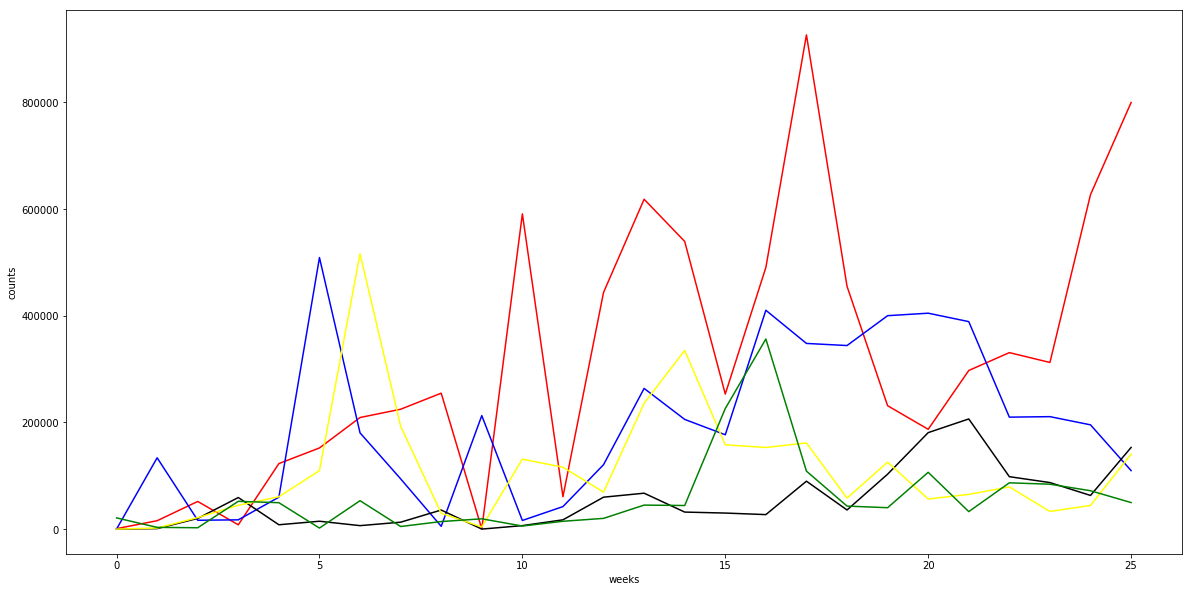

In [23]:
x_val = []

y1 = []
y2 = []
y3 = []
y4 = []
y5 = []

for i in range(0, 26):
    y1.append(test_data[0].get('data')[i].get('count'))
    y2.append(test_data[1].get('data')[i].get('count'))
    y3.append(test_data[2].get('data')[i].get('count'))
    y4.append(test_data[3].get('data')[i].get('count'))
    y5.append(test_data[4].get('data')[i].get('count'))
    x_val.append(i)

plt.figure(figsize=(20,10))

plt.plot(x_val, y1, 'r-', color='red')  # week in question=RED
plt.plot(x_val, y2, 'r-', color='blue')  # mean=BLACK
plt.plot(x_val, y3, 'r-',color='black')  # mean=BLACK
plt.plot(x_val, y4, 'r-',color='yellow')  # mean=BLACK
plt.plot(x_val, y5, 'r-',color='green')  # mean=BLACK


ax = plt.gca()

ax.set_xlabel('weeks')
ax.set_ylabel('counts')

plt.show()    


In [ ]:
# Problem. Need to Fill zeroes. Again.